In [1]:
from google.colab import drive, output
drive.mount('/content/drive')
import sys
%cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
#sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
#sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
%load_ext autoreload
%autoreload 1
!pip install torchaudio
!pip install umap
!pip install wandb --upgrade
!wandb login
output.clear()

In [ ]:
from __future__ import print_function
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import IPython

from six.moves import xrange

import umap
import wandb
import torch
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.empty_cache()

from scipy import signal
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim

from torch.utils.data import random_split
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torch.nn.functional as F

#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader import SoundscapeData
from Models import Model
from Models import Encoder
from Models import Decoder
from Models import VectorQuantizer
from Models import VectorQuantizerEMA

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

from datetime import timedelta
import wandb
from wandb import AlertLevel

wandb.login()

cuda


wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


True

## Train

We use the hyperparameters from the author's code:

In [ ]:
root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Jaguas_2018'


dataset = SoundscapeData(root_path, 1, "wav")
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.10), len(dataset) - round(len(dataset)*0.10)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "batch_size" : 8,
    "num_epochs": 3,
    "num_training_updates" : len(dataset_train),
    "num_hiddens" : 64,
    "embedding_dim" : 128,
    "num_embeddings" : 64,
    "commitment_cost" : 0.25,
    "decay" : 0.99,
    "learning_rate" : 1e-3,
    "dataset": "Audios Jaguas",
    "architecture": "VQ-VAE",
}

run_name = "Few_layers_10s_Batch_size: "+ str(config["batch_size"]) +" num_hiddens: " + str(config["num_hiddens"]) +" num_embeddings: " + str(config["num_embeddings"]) +" embedding dim: "+  str(config["embedding_dim"])

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"], shuffle = False)
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])


model = Model(config["num_hiddens"],
              config["num_embeddings"], config["embedding_dim"], 
              config["commitment_cost"], config["decay"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)


wandb.finish()
wandb.init(project="VQ-VAE-Jaguas", config=config)
wandb.run.name = run_name
wandb.run.save()
wandb.watch(model)


In [ ]:
dataset.

In [ ]:
def plot_reconstructions(imgs_original, imgs_reconstruction, num_views: int=8):
    output = torch.cat((imgs_original[0:num_views], imgs_reconstruction[0:num_views]), 0)
    img_grid = make_grid(output, nrow=8, pad_value=20)
    fig, ax = plt.subplots(figsize=(20,5))
    ax.imshow(img_grid[1,:,:].cpu(), vmin=0, vmax=1)
    ax.axis("off")
    plt.show()
    return fig

def testModel(model, iterator):
    model.eval()
    (valid_originals, _,_) = next(iterator)
    valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1], 
                                                  valid_originals.shape[2], valid_originals.shape[3]))
    valid_originals = torch.unsqueeze(valid_originals,1)

    valid_originals = valid_originals.to(device)

    vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
    _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)
    
    fig = plot_reconstructions(valid_originals, valid_reconstructions, 8)

    recon_error = F.mse_loss(valid_originals, valid_reconstructions)

    return fig, recon_error


In [ ]:
model.train()
train_res_recon_error = []
train_res_perplexity = []
iterator = iter(test_loader)
wandb.watch(model, F.mse_loss, log="all", log_freq=1)
error_files = []

for epoch in range(config["num_epochs"]):
  for i in xrange(config["num_training_updates"]):
      model.train()
      try:
          (data, _,_) = next(iter(training_loader))
      except Exception as e:
          error_files.append(e)
          continue
          
      data = torch.reshape(data, (data.shape[0] * data.shape[1], data.shape[2], data.shape[3]))
      data = torch.unsqueeze(data,1)
      data = data.to(device)
      print(data.shape)

      optimizer.zero_grad()
      vq_loss, data_recon, perplexity = model(data)
      print(data_recon.shape)
      
      recon_error = F.mse_loss(data_recon, data) #/ data_variance
      loss = recon_error + vq_loss
      loss.backward()

      optimizer.step()

      wandb.log({"loss":loss.item(),
                 "perplexity":perplexity.item(),
                 "recon_error": recon_error,
                 "vq_loss": vq_loss})
      print(f'epoch: {epoch} of {config["num_epochs"]} \t iteration: {(i+1)} of {config["num_training_updates"]} \t loss: {np.round(loss.item(),4)} \t recon_error: {np.round(recon_error.item(),4)} \t vq_loss: {np.round(vq_loss.item(),4)}')

      torch.cuda.empty_cache()

      # if (i+1) % 5 == 0:
      #   plot_reconstructions(data, data_recon)
      
      if (i+1) % 100 == 0:
        try:
            #torch.save(model.state_dict(),f'model_{epoch}_{i}.pkl')
            fig, test_error = testModel(model, iterator)
            images = wandb.Image(fig, caption= f"recon_error: {np.round(test_error.item(),4)}")
            wandb.log({"examples": images})
            #wandb.log({"config": config})
        except Exception as e:
            error_files.append(e)
            continue

      if recon_error < 1:
    
          wandb.alert(
            title='High accuracy',
            text=f'Recon error {recon_error} is lower than .5',
            level=AlertLevel.WARN,
            wait_duration=timedelta(minutes=5)
                      ) 
                
          torch.save(model.state_dict(),f'{run_name}_low_error.pkl')
                  
wandb.finish()


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)
torch.save(model.state_dict(),f'{run_name}.pkl')

In [ ]:
model.load_state_dict(torch.load('Models/Few_layers_1s_Batch_size_8_num_hiddens_64_num_embeddings_64_embedding_dim_128.pkl', map_location=torch.device('cpu')))

<All keys matched successfully>

In [ ]:
root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Porce_2019'


dataset = SoundscapeData(root_path=root_path, audio_length=59, ext='WAV')
dataset_train, dataset_test = random_split(dataset,
         ounddevice                                  [round(len(dataset)*0.10), len(dataset) - round(len(dataset)*0.10)], 
                                           generator=torch.Generator().manual_seed(1024))

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"], shuffle = False)
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])


In [ ]:
iterator = iter(test_loader)
originals, record, sr = iterator.next()

In [ ]:
def plot_reconstructions(imgs_original, imgs_reconstruction, num_views: int=8):
    output = torch.cat((imgs_original[0:num_views], imgs_reconstruction[0:num_views]), 0)
    img_grid = make_grid(output, nrow=8, pad_value=20)
    fig, ax = plt.subplots(figsize=(20,5))
    ax.imshow(img_grid[1,:,:].cpu(), vmin=0, vmax=1)
    ax.axis("off")
    plt.show()
    return fig

def testModel(model, iterator):
    model.eval()
    (valid_originals, _,_) = iterator.next()
    valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1], 
                                                  valid_originals.shape[2], valid_originals.shape[3]))
    valid_originals = torch.unsqueeze(valid_originals,1)

    valid_originals = valid_originals.to(device)

    vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
    _, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
    valid_reconstructions = model._decoder(valid_quantize)
    
    fig = plot_reconstructions(valid_originals, valid_reconstructions, 8)

    recon_error = F.mse_loss(valid_originals, valid_reconstructions)

    return fig, recon_error, valid_reconstructions, valid_originals

fig, test_error, reconstruction, originals = testModel(model, iterator)


In [ ]:
import torchaudio.transforms as audio_transform
reconstruction = reconstruction.cdouble()
reconstruction = reconstruction.to("cpu")
originals = originals.cdouble()
originals = originals.to("cpu")
transformation = audio_transform.InverseSpectrogram(n_fft=256, win_length = 256)
waveform = transformation(reconstruction)
waveform_original = transformation(originals)
waveform = waveform.cpu().detach().numpy()
waveform_original = waveform_original.cpu().detach().numpy()

RuntimeError: ignored

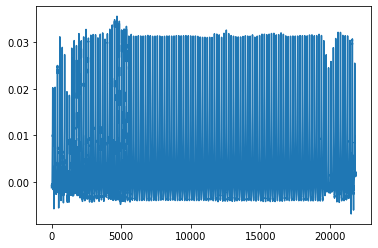

AttributeError: ignored

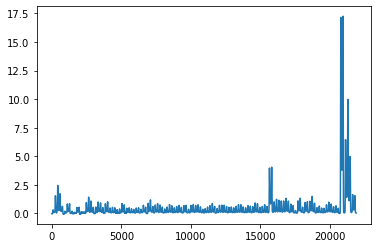

In [ ]:
import matplotlib.pyplot as plt

plt.plot(waveform[0,0])
plt.show()
plt.figure()
plt.plot(waveform_original[0,0])

In [ ]:
from scipy.io.wavfile import write

scaled = np.int16(waveform_original[0, 0]/np.max(np.abs(waveform_original[0 ,0])) * 32767)
write('waveform_original.wav', 22050, scaled)

scaled2 = np.int16(waveform[0, 0]/np.max(np.abs(waveform[0 ,0])) * 32767)
write('waveform.wav', 22050, scaled2)



## Plot Loss

In [ ]:
train_res_recon_error_smooth = savgol_filter(train_res_recon_error, 201, 7)
train_res_perplexity_smooth = savgol_filter(train_res_perplexity, 201, 7)

In [ ]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(1,2,1)
ax.plot(train_res_recon_error_smooth)
ax.set_yscale('log')
ax.set_title('Smoothed NMSE.')
ax.set_xlabel('iteration')

ax = f.add_subplot(1,2,2)
ax.plot(train_res_perplexity_smooth)
ax.set_title('Smoothed Average codebook usage (perplexity).')
ax.set_xlabel('iteration')

In [ ]:
model.eval()
validation_loader = training_loader
(valid_originals, _,_,_) = next(iter(validation_loader),30000)

## View Reconstructions

In [ ]:
model.eval()
validation_loader = training_loader
(valid_originals, _,_,_) = next(iter(validation_loader),3000)
valid_originals = torch.reshape(valid_originals, (valid_originals.shape[0] * valid_originals.shape[1], valid_originals.shape[2], valid_originals.shape[3]))
valid_originals = torch.unsqueeze(valid_originals,1)

print(valid_originals.shape)



valid_originals = valid_originals.to(device)

vq_output_eval = model._pre_vq_conv(model._encoder(valid_originals))
_, valid_quantize, _, _ = model._vq_vae(vq_output_eval)
valid_reconstructions = model._decoder(valid_quantize)

In [ ]:
def showTensor(tensor, dim):
    return tensor[dim,:,:,:].cpu().detach().numpy()[0,:,:]

In [ ]:
plt.figure(figsize=(40,40))

plt.subplot(5,2,1)
plt.imshow(showTensor(valid_originals,0),vmin=0,vmax=0.7)
plt.subplot(5,2,2)
plt.imshow(showTensor(valid_reconstructions,0),vmin=0,vmax=0.7)
plt.subplot(5,2,3)
plt.imshow(showTensor(valid_originals,1),vmin=0,vmax=0.7)
plt.subplot(5,2,4)
plt.imshow(showTensor(valid_reconstructions,1),vmin=0,vmax=0.7)
plt.subplot(5,2,5)
plt.imshow(showTensor(valid_originals,2),vmin=0,vmax=0.7)
plt.subplot(5,2,6)
plt.imshow(showTensor(valid_reconstructions,2),vmin=0,vmax=0.7)
plt.subplot(5,2,7)
plt.imshow(showTensor(valid_originals,3),vmin=0,vmax=0.7)
plt.subplot(5,2,8)
plt.imshow(showTensor(valid_reconstructions,3),vmin=0,vmax=0.7)
plt.subplot(5,2,9)
plt.imshow(showTensor(valid_originals,4),vmin=0,vmax=0.7)
plt.subplot(5,2,10)
plt.imshow(showTensor(valid_reconstructions,4),vmin=0,vmax=0.7)
#plt.savefig("VQVAE_Sin_Residual.pdf")

In [ ]:
(train_originals, _,_,_) = next(iter(training_loader))
train_originals = train_originals.to(device)
_, train_reconstructions, _, _ = model._vq_vae(train_originals)

In [ ]:
def show(img):
    npimg = img.numpy()
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)

In [ ]:
show(make_grid(valid_reconstructions.cpu().data)+0.5, )

In [ ]:
show(make_grid(valid_originals.cpu()+0.5))

## View Embedding

In [ ]:
import umap
proj = umap(n_neighbors=3,
                 min_dist=0.1,
                 metric='cosine').fit_transform(model._vq_vae._embedding.weight.data.cpu())

In [ ]:
plt.scatter(proj[:,0], proj[:,1], alpha=0.3)

NameError: ignored